# ML1617 - What's cooking?

## Facts about the data

In [1]:
import re

import pandas
from nltk.stem import WordNetLemmatizer

train = pandas.read_json('data/cooking_train.json')
print('recipes: ', train.shape[0])
print('cuisines', sorted(set(train.cuisine)))

def words():
    for ingredient_list in train.ingredients:
        for ingredient in ingredient_list:
            yield from ingredient.split()


def letters():
    for word in words():
        yield from word


non_char_regex = re.compile('[^a-z]')
def simplify(word):
    return non_char_regex.sub('', word.lower())

letters = set(letters())
print('letters', sorted(letters), "total", len(letters))
print('max length', max(len(';'.join(ingredient_list)) for ingredient_list in train.ingredients))
print('distinct words', sum(1 for word in set(words())))
print('simplified words', sum(1 for _ in set(simplify(word) for word in words())))
lemmatizer = WordNetLemmatizer()
print('distinct lemmatized words', sum(1 for word in set(lemmatizer.lemmatize(word) for word in words())))
print('distinct simplified and lemmatized words', sum(1 for word in set(lemmatizer.lemmatize(simplify(word)) for word in words())))
print('words', sum(1 for word in words()))

recipes:  30000
cuisines ['brazilian', 'british', 'cajun_creole', 'chinese', 'filipino', 'french', 'greek', 'indian', 'irish', 'italian', 'jamaican', 'japanese', 'korean', 'mexican', 'moroccan', 'russian', 'southern_us', 'spanish', 'thai', 'vietnamese']
letters ['!', '%', '&', "'", '(', ')', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '®', 'â', 'ç', 'è', 'é', 'í', 'î', 'ú', '’', '€', '™'] total 81
max length 980
distinct words 3386
simplified words 2910
distinct lemmatized words 3183
distinct simplified and lemmatized words 2695
words 609069


In [2]:
train.head(10)

,cuisine,id,ingredients
0,chinese,29565,"[romaine lettuce, sliced almonds, vegetable oi..."
1,italian,15528,"[pistachios, dried fig, bread ciabatta, extra-..."
2,cajun_creole,38015,"[olive oil, lemon, chili sauce, shrimp, butter..."
3,italian,20511,"[fresh basil, olive oil, potato gnocchi, garli..."
4,chinese,44111,"[honey, portabello mushroom, tamari soy sauce,..."
5,southern_us,12783,"[brown sugar, cooking spray, all-purpose flour..."
6,southern_us,16680,"[egg whites, fresh lemon juice, yellow food co..."
7,italian,22279,"[yellow corn meal, extra-virgin olive oil, dri..."
8,spanish,15389,"[eggs, almonds, red bell pepper, onions, dried..."
9,chinese,1036,"[cold water, white pepper, salt, chicken broth..."


## Introduction

I have tried out multiple approaches, both involving algorithms available with sklearn, neural networks models (fixed input and RNNs) and xgboost. Unfortunatelly, none of my approaches beat simple MLP model freely available on Github, so I used that one for Kaggle.

For vectorizing/emedding, the best approach appeared to be treating each cleaned world (removed special chars, lowercased, lemmatized using NLTK and WordNet) and each ingredient as a whole as a separate feature.

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import pandas

def my_train_test_split(X, y):
    return train_test_split(X, y, test_size=0.2, random_state=42)

def read_data():
    labeled = pandas.read_json("data/cooking_train.json")
    labeled_X, labeled_Y = labeled['ingredients'], labeled['cuisine']
    unlabeled = pandas.read_json("data/cooking_test.json")
    unlabeled_X, unlabeled_ids = unlabeled['ingredients'], unlabeled['id']
    return labeled_X, labeled_Y, unlabeled_X, unlabeled_ids

def save_submission(test_ids, test_guess):
    submission = pandas.DataFrame({"id": test_ids, "cuisine": test_guess})
    submission.to_csv("data/my_submission_1.csv", index=False)


labeled_X, labeled_y, unlabeled_X, unlabeled_ids = read_data()
train_X, val_X, train_y, val_y = my_train_test_split(labeled_X, labeled_y)

In [4]:
classes = sorted(set(labeled_y))

## Multilayer perceptron approach

Based on https://github.com/ogencoglu/WhatsCooking.

Input processing: each word and each ingredient is a separate feature. A list of ingredients is encoded as boolean vector with True if it contains given feature or False if it doesn't.

Model: 3 dense layers with 0.5 dropout between them.

Adding regularization and batch normalization hasn't shown significant improvement to the model on the validation set.

_Technical detail: the solution executes multiple processes. The script appeared to be leaking memory (tensorflow fault most probably), so each training and prediction is run as a separate process._

**I was unable to run it with notebook - my GPU is only accessible over an unstable SSH connection, which makes Jupyter unusable. The next example (ensemble using sklearn) has the answers filled in.**

In [ ]:
import mlp

In [ ]:
mlp_labeled_X, mlp_labeled_y, mlp_unlabeled_X, label_transformer = mlp.prepare_data(
    labeled_X, labeled_y, unlabeled_X)
mlp_train_X, mlp_val_X, mlp_train_y, mlp_val_y = my_train_test_split(
    mlp_labeled_X, mlp_labeled_y)

In [ ]:
mlp.prepare_train(mlp_train_X, mlp_train_y, (mlp_val_X, mlp_val_y))

In [ ]:
mlp.clear_weights()

In [ ]:
!python -m mlp.train_all 10

In [ ]:
val_guess = mlp.predict(mlp_val_X, label_transformer)
print("Score", accuracy_score(val_y, val_guess))

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix_test = confusion_matrix(val_y, val_guess, classes)

%matplotlib inline
from matplotlib import pyplot
from lib import plot_confusion_matrix
pyplot.figure(figsize=(10, 10))
plot_confusion_matrix(confusion_matrix_test, classes, normalize=True)
pyplot.figure(figsize=(10, 10))
plot_confusion_matrix(confusion_matrix_test, classes, normalize=False)



In [ ]:
mlp.clear_weights()
mlp.prepare_train(mlp_labeled_X, mlp_labeled_y, None)
!python -m mlp.train_all 10
unlabeled_mlp_guess = mlp.predict(mlp_unlabeled_X, label_transformer)

In [ ]:
save_submission(unlabeled_ids, unlabeled_mlp_guess)

## Sklearn approach

A mix of linear SVM, logistic regression and extra trees ensembled using voting classifier. TfidfVectorizer has been used for preprocessing.

LinearSVM has regularization C=5 and logistic regression has regularization C=0.5. These values have been decided using GridSearchCV.

Voting classifier weights: 2 for logistic regression, 2 for SVM and 1 for extra trees. The weights have been decided using GridSearchCV. Inutitively, when SVM and logreg agree, then their output is the prediction of the ensemble. If they disagree and ET has the same prediction as one of these, then the prediction is chosen.

In [5]:
import voting

voting_model = voting.get_model()
voting_model.fit(train_X, train_y)
print("score", voting_model.score(val_X, val_y))

score 0.795166666667


###  Confusion matrix

In [6]:
val_voting_guess = voting_model.predict(val_X)

In [7]:
from sklearn.metrics import confusion_matrix
confusion_matrix_test = confusion_matrix(val_y, val_voting_guess, classes)

Normalized confusion matrix
Confusion matrix, without normalization


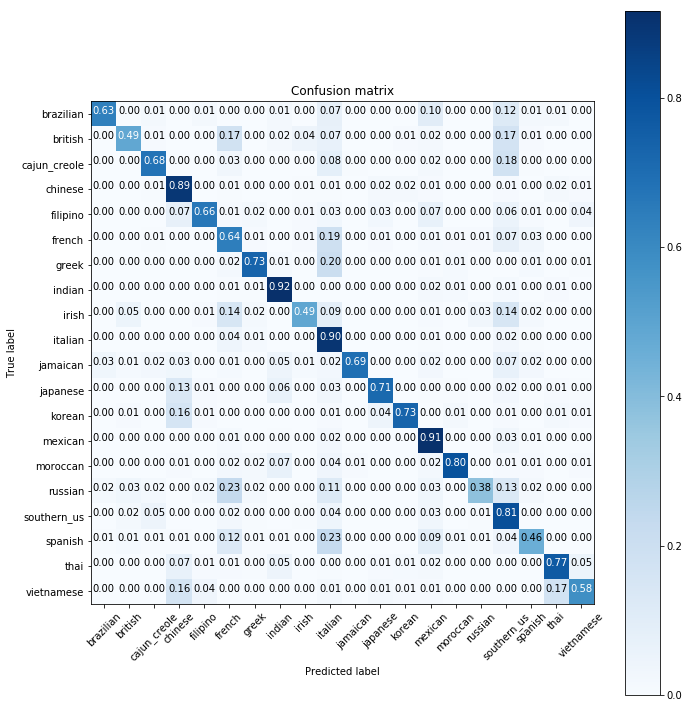

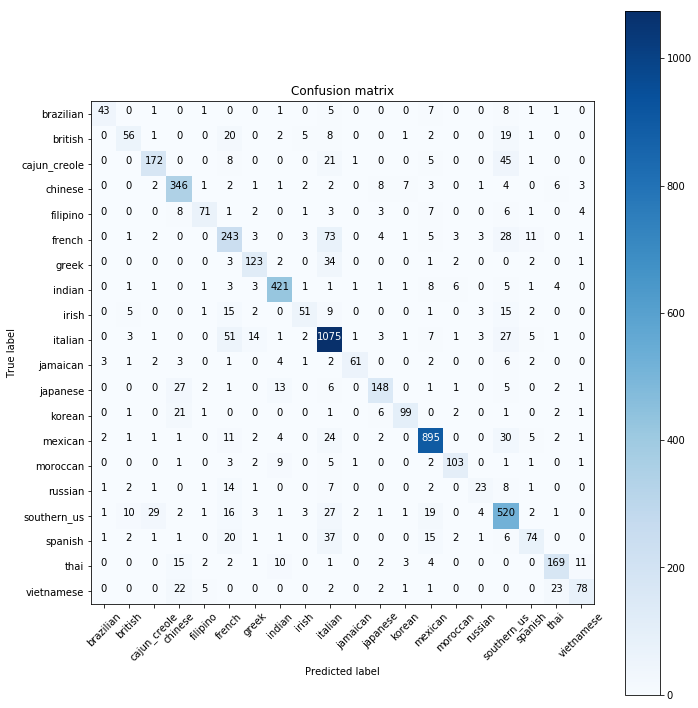

In [8]:
%matplotlib inline
from matplotlib import pyplot
from lib import plot_confusion_matrix
pyplot.figure(figsize=(10, 10))
plot_confusion_matrix(confusion_matrix_test, classes, normalize=True)
pyplot.figure(figsize=(10, 10))
plot_confusion_matrix(confusion_matrix_test, classes, normalize=False)


## Other approaches

Other selected approaches are included as separate Python scripts and they are not included into the Python notebook.

|Description | Accuracy | How to run
|---|---|
| LSTM - each (cleaned) word is one piece of input, with augmentation | 0.7850 | python -m other.lstm_by_char |
| LSTM - each char is one piece of input, with augmentation | 0.6439 | python -m other.lstm_by_word | 
| xgboost\* | 0.6858 | python -m other.xgboost_cooking |
| Logistic regression | 0.7868 | python -m other.logreg |
| Linear SVC | 0.7889 | python -m other.linearsvc |

\* Requires installing xgboost, which is not in the requirements.txt.